# Import thư viện

In [1]:
# Thư viện cơ bản
import pandas as pd
import numpy as np

# Thư viện vẽ biểu đồ
import matplotlib.pyplot as plt
import seaborn as sns

# Tiền xử lý
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

# Thư viện mô hình
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB

# Chia train, test & tối ưu hóa
from sklearn.model_selection import train_test_split, GridSearchCV

# Thư viện đánh giá
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('/content/Book11212312312312.csv')
df.shape

(379, 17)

# Tiền xử lý

In [3]:
# Drop cột ko cần thiết
df.drop(columns=['Review_Date', 'lat', 'lng'], inplace=True)

## Chia dữ liệu trong cột "Tags"

In [4]:
df['Tags'] = df['Tags'].astype(str)

In [5]:
df['Tags'] = df['Tags'].apply(lambda x: eval(x.strip()))

# Tách các giá trị thành các cột riêng
tags_df = pd.DataFrame(df['Tags'].tolist())

# Đổi tên cột
tags_df.columns = [f"Tags_{i+1}" for i in range(tags_df.shape[1])]

# Kết hợp vào DataFrame ban đầu
df = pd.concat([df, tags_df], axis=1)

# Bỏ cột 'tag' gốc nếu không cần thiết
df = df.drop('Tags', axis=1)

## Biến nothing, no negative, no positive thành nothing để dễ mã hóa

In [15]:
def normalize_value(value):
    value = str(value).strip().lower()
    if value in ['nothing', 'no negative', ' nothing', ' no negative', 'no positive', ' no postive']:
        return 'nothing'
    return value
df['Negative_Review'] = df['Negative_Review'].apply(normalize_value)
df['Positive_Review'] = df['Positive_Review'].apply(normalize_value)
df.head(10)

In [12]:
# Chuyển "nothing" thành 0, tất cả các giá trị khác thành 1
df['Negative_Review'] = df['Negative_Review'].apply(lambda x: 0 if x == "nothing" else 1)

In [13]:
# Chuyển "nothing" thành 0, tất cả các giá trị khác thành 1
df['Positive_Review'] = df['Positive_Review'].apply(lambda x: 0 if x == "nothing" else 1)

In [14]:
df.head(10)

,Hotel_Address,Additional_Number_of_Scoring,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,days_since_review,Reviewer_Score,Tags_1,Tags_2,Tags_3,Tags_4,Tags_5
0,44 Grosvenor Square Westminster Borough London...,806,7.8,Millennium Hotel London Mayfair,Qatar,1,6,3117,1,4,9,76 days,Intermediate_Reviewer_Score,Leisure trip,Family with young children,Club Double Room,Stayed 6 nights,Submitted from a mobile device
1,Bryanston Street Marble Arch Westminster Borou...,908,8.5,Amba Hotel Marble Arch,United Kingdom,0,2,3980,1,5,1,492 day,High_Reviewer_Score,Leisure trip,Group,Standard Twin Room,Stayed 3 nights,Submitted from a mobile device
2,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,Belgium,1,14,16670,1,19,23,345 day,Intermediate_Reviewer_Score,Leisure trip,Couple,Double Room,Stayed 1 night,None
3,17 rue de l Arcade 8th arr 75008 Paris France,230,8.6,H tel Bedford,United Kingdom,0,2,1703,1,3,6,385 day,High_Reviewer_Score,Leisure trip,Family with older children,Double Room with Extra Bed,Stayed 1 night,Submitted from a mobile device
4,57 59 Welbeck Street Westminster Borough Londo...,241,7.5,Holiday Inn London Oxford Circus,Israel,1,58,1287,1,17,3,73 days,Intermediate_Reviewer_Score,Leisure trip,Couple,Double Room,Stayed 4 nights,None
5,Avenida Meridiana 151 Sant Mart 08026 Barcelon...,541,7.9,Catalonia Atenas,Lithuania,1,26,6792,1,17,4,372 day,High_Reviewer_Score,Leisure trip,Couple,Double or Twin Room,Stayed 5 nights,None
6,42 46 Chiswell Street City of London London EC...,417,8.9,London City Suites,France,1,51,1744,1,26,10,528 day,Intermediate_Reviewer_Score,Family with older children,2 rooms,Stayed 2 nights,None,None
7,Nieuwe Doelenstraat 2 14 Amsterdam City Center...,95,9.1,De L Europe Amsterdam,United Kingdom,1,16,551,1,6,13,655 day,Intermediate_Reviewer_Score,Leisure trip,Couple,Superior Double Room,Stayed 1 night,Submitted from a mobile device
8,6 Waterloo Place Westminster Borough London SW...,240,9.2,Sofitel London St James,Saudi Arabia,0,0,1284,1,76,13,333 day,High_Reviewer_Score,Leisure trip,Family with young children,Superior Queen Room,Stayed 6 nights,Submitted from a mobile device
9,Piazza Duca D Aosta 4 6 Central Station 20124 ...,639,8.8,Glam Milano,China,0,0,7371,1,36,16,384 day,High_Reviewer_Score,Business trip,Group,Standard Twin Room,Stayed 1 night,None


In [16]:
# Gộp nhãn: Low và Intermediate thành 0, High thành 1 (do số lượng dòng của Low quá ít)
mapping = {
    "Low_Reviewer_Score": 0,
    "Intermediate_Reviewer_Score": 0,
    "High_Reviewer_Score": 1
}

df['Reviewer_Score'] = df['Reviewer_Score'].map(mapping)

In [10]:
# Lọc ra những cột định tính để mã hóa nốt
cate_cols = df.select_dtypes(include=['object']).columns
cate_cols

Index(['Hotel_Address', 'Hotel_Name', 'Reviewer_Nationality', 'Tags_1',
       'Tags_2', 'Tags_3', 'Tags_4', 'Tags_5', 'Tags_6'],
      dtype='object')

In [11]:
le = LabelEncoder()
for cols in cate_cols:
  df[cols] = le.fit_transform(df[cols])

<Axes: xlabel='Reviewer_Score', ylabel='Count'>

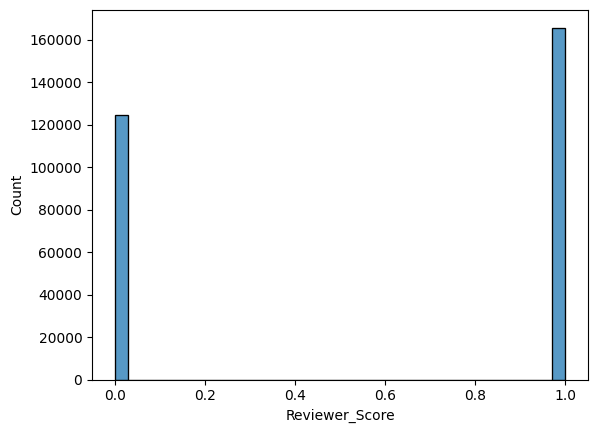

In [12]:
sns.histplot(x=df['Reviewer_Score'])

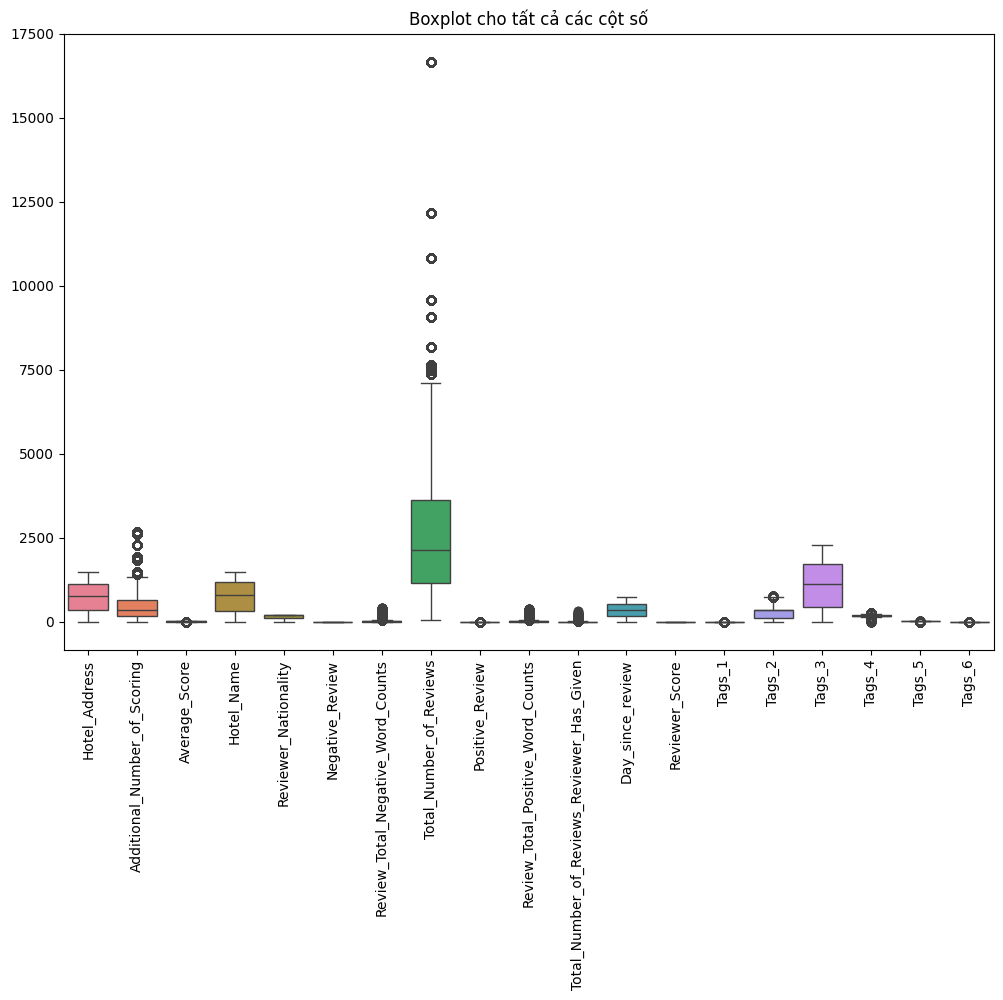

In [13]:
# Vẽ box plot để kiểm tra ngoại lai

plt.figure(figsize=(12, 8))

# Vẽ boxplot cho tất cả các cột số
sns.boxplot(data=df)

# Hiển thị
plt.xticks(rotation=90)
plt.title("Boxplot cho tất cả các cột số")
plt.show()

In [14]:
# Xử lí ngoại lai bằng cách xóa
for cols in df.columns:
  iqr = df[cols].quantile(0.75) - df[cols].quantile(0.25)
  upper_bound = df[cols].quantile(0.75) + 1.5 * iqr
  lower_bound = df[cols].quantile(0.25) - 1.5 * iqr
  df = df[(df[cols] >= lower_bound) & (df[cols] <= upper_bound)]

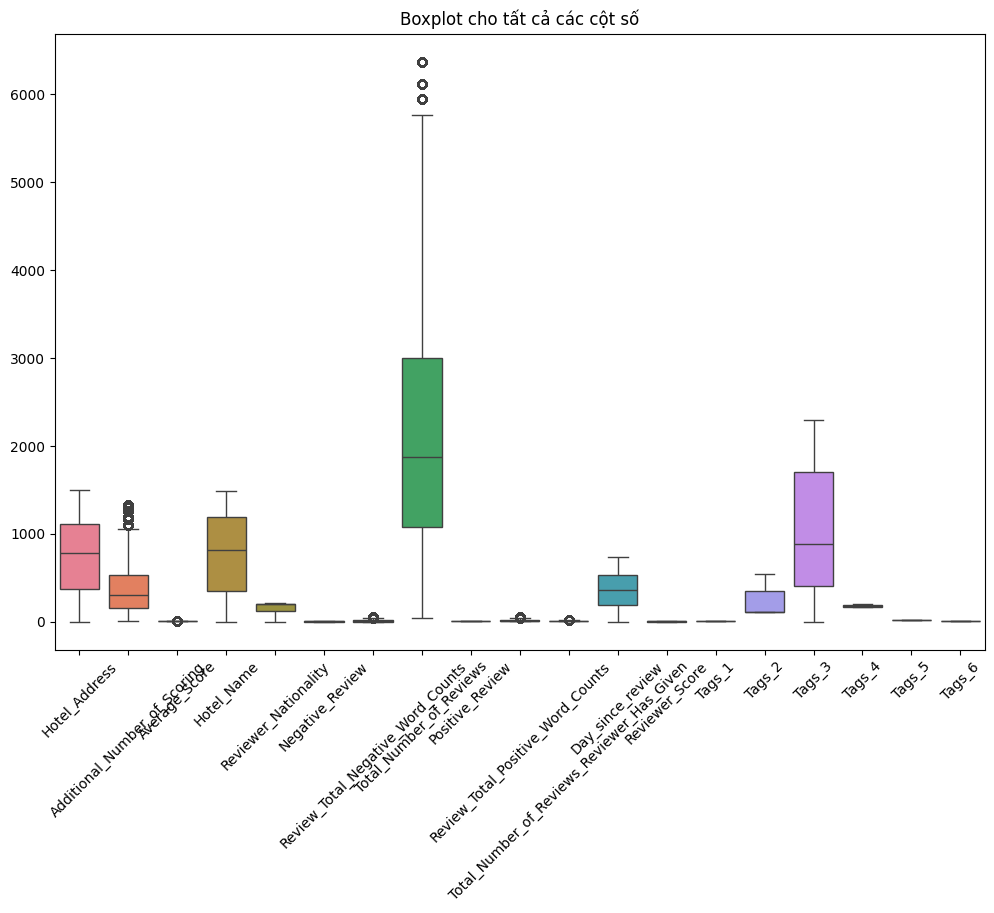

In [15]:
# Box plot sau khi xử lí ngoại lai
plt.figure(figsize=(12, 8))

# Vẽ boxplot cho tất cả các cột số
sns.boxplot(data=df)

# Hiển thị
plt.xticks(rotation=45)
plt.title("Boxplot cho tất cả các cột số")
plt.show()

# Chia train test, chuẩn hóa

In [16]:
X = df.drop(columns=['Reviewer_Score'])
y = df['Reviewer_Score']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
# Dùng SMOTE để cân bằng lại nhãn
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [19]:
# Chuẩn hóa giá trị
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
y_train.value_counts()

,count
Reviewer_Score,
0,71244
1,71244


# Chạy mô hình

In [29]:
gauss = GaussianNB()
gauss.fit(X_train, y_train)

GaussianNB()

In [30]:
y_pred = gauss.predict(X_test)

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.75      0.64     16618
           1       0.84      0.67      0.75     30707

    accuracy                           0.70     47325
   macro avg       0.70      0.71      0.69     47325
weighted avg       0.74      0.70      0.71     47325



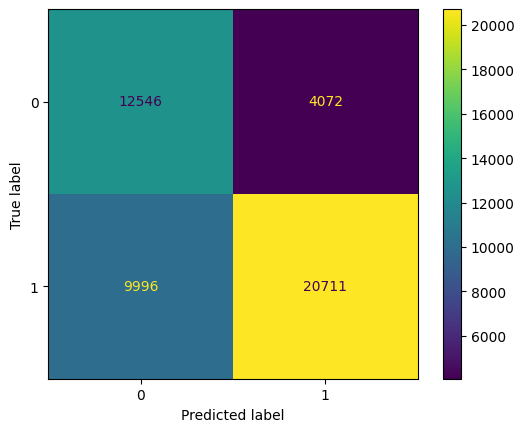

In [32]:
ConfusionMatrixDisplay.from_estimator(gauss, X_test, y_test)

# Tối ưu mô hình

In [33]:
# Bảng chọn siêu tham số để tìm ra siêu tham số đẹp nhất
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

In [34]:
# Dùng gridsearchCV để tìm siêu tham số
grid = GridSearchCV(gauss, param_grid, cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06]},
             verbose=1)

In [35]:
gauss_best = grid.best_estimator_

In [36]:
# Câu lệnh này lấy xác suất dự đoán rằng mỗi mẫu trong tập `X_test` thuộc lớp 1 (lớp dương) từ mô hình đã huấn luyện.
y_proba = grid.predict_proba(X_test)[:, -1]

In [42]:
# Tạo ra nhiều giá trị ngưỡng (threshold) chạy từ 0.0 đến 1.0 - bước nhảy 0.01
threshold = np.arange(0.0, 1.01, 0.01)

# Mảng chứa kết quả từ ma trận nhầm lẫn
results = []

# Kết quả của ma trận từ ngưỡng 0.0 đến 1.0
for t in threshold:
    y_pred = (y_proba > t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    results.append((t, fp, fn, tp, tn))

In [43]:
# Đoạn code này tạo một DataFrame để tính Precision và Recall tại các ngưỡng (`threshold`)
# khác nhau dựa trên số lượng TP, FP, FN, TN từ kết quả mô hình.

df_thresh = pd.DataFrame(results, columns=['threshold', 'fp', 'fn', 'tp', 'tn'])
df_thresh['Precision'] = df_thresh['tp'] / (df_thresh['tp'] + df_thresh['fp'])
df_thresh['Recall'] = df_thresh['tp'] / (df_thresh['tp'] + df_thresh['fn'])

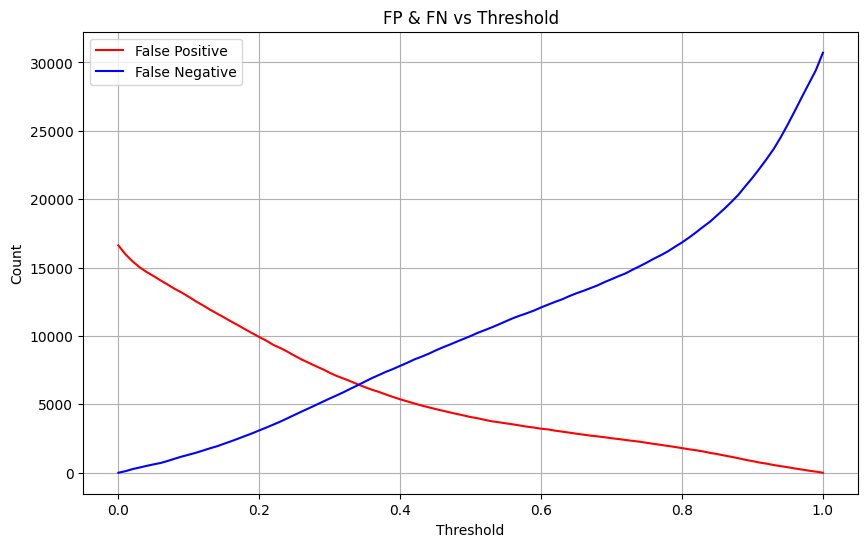

In [44]:
# Vẽ biểu đồ FP và FN theo ngưỡng
plt.figure(figsize=(10,6))
plt.plot(df_thresh['threshold'], df_thresh['fp'], label='False Positive', color='red')
plt.plot(df_thresh['threshold'], df_thresh['fn'], label='False Negative', color='blue')
plt.xlabel('Threshold')
plt.ylabel('Count')
plt.title('FP & FN vs Threshold')
plt.legend()
plt.grid()
plt.show()

In [48]:
# Chọn ngưỡng tốt nhất
y_pred_best = (y_proba > 0.4).astype(int)

In [49]:
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.59      0.68      0.63     16618
           1       0.81      0.75      0.78     30707

    accuracy                           0.72     47325
   macro avg       0.70      0.71      0.70     47325
weighted avg       0.73      0.72      0.73     47325



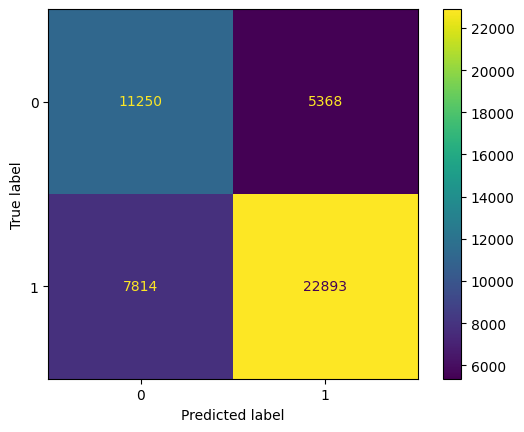

In [51]:
cm_best = confusion_matrix(y_test, y_pred_best)
ConfusionMatrixDisplay(cm_best).plot()

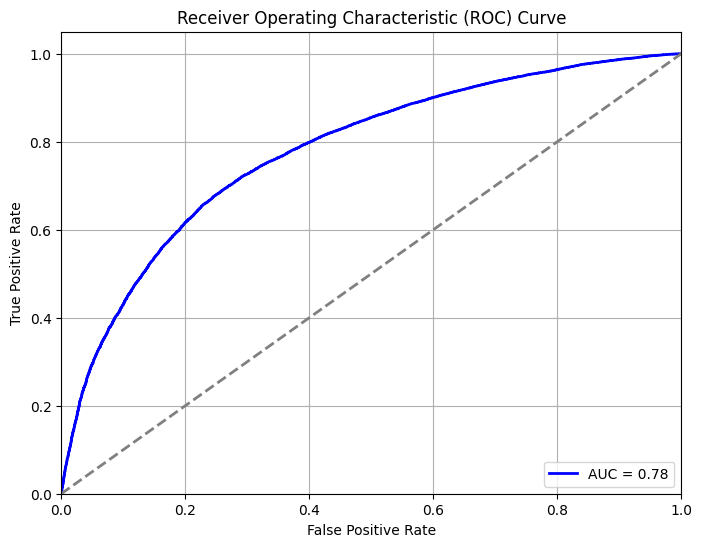

In [52]:
# Vẽ đường cong thao tác nhân (ROC), AUC >= 0.65 thì mô hình mới có khả năng phân loại
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # đường random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()